In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [4]:
# Vocabulary
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def findFiles(path): return glob.glob(path)

In [5]:
data_dir = os.path.join(os.pardir, 'data', 'worldcities.csv')
raw_df = pd.read_csv(data_dir)[['city_ascii', 'country']]

# Listing all cities for each country
grouped_cities = raw_df.groupby('country')['city_ascii'].apply(list).reset_index(name='cities')

# Removing all countries where number of cities < 100
city_count = raw_df.groupby('country').count().reset_index()
countries_to_keep = city_count[city_count.city_ascii > 100].country
grouped_cities = grouped_cities[grouped_cities.country.isin(countries_to_keep)]


# Preparing country city dict and label list
all_countries = grouped_cities['country'].unique().tolist()
city_dict = {country: city_lst for country, city_lst in grouped_cities.to_numpy()}
n_categories = len(all_countries)
print(n_categories)

50


In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.hidden_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_comp = nn.Linear(input_size + hidden_size, hidden_size)
        self.output2output = nn.Linear(hidden_size, output_size)
        self.tanh_act = nn.Tanh()
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        
        combined = torch.cat((x, hidden), 1)
        hidden = self.hidden_comp(combined)
        hidden = self.tanh_act(hidden)
        
        output = self.output_comp(combined)
        output = self.tanh_act(output)
        output = self.output2output(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_countries[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_countries)
    line = randomChoice(city_dict[category])
    category_tensor = torch.tensor([all_countries.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)

    # Iterate through the whole line!
    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

In [9]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_basic = RNN(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_basic = model_basic.to(device)
optimizer = optim.SGD(model_basic.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor, optimizer, criterion, model_basic)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 23s) 3.9112 Vila de Porto Santo / Poland ✗ (Portugal)
10000 10% (0m 40s) 3.8976 Korfez / Poland ✗ (Turkey)
15000 15% (0m 57s) 3.7162 Khondab / Syria ✗ (Iran)
20000 20% (1m 14s) 3.2819 Mouguerre / United Kingdom ✗ (France)
25000 25% (1m 30s) 3.0060 Moraleja de Enmedio / Italy ✗ (Spain)
30000 30% (1m 47s) 2.4695 Munchenstein / Austria ✗ (Switzerland)
35000 35% (2m 6s) 3.0639 Hailin / Syria ✗ (China)
40000 40% (2m 22s) 4.3695 Remedios / France ✗ (Colombia)
45000 45% (2m 37s) 3.3708 Tekmal / Kazakhstan ✗ (India)
50000 50% (2m 52s) 2.3305 El Pino / Italy ✗ (Dominican Republic)
55000 55% (3m 7s) 2.4657 Vel'ky Saris / Bulgaria ✗ (Slovakia)
60000 60% (3m 22s) 4.6923 Zapala / India ✗ (Argentina)
65000 65% (3m 37s) 2.7214 Florencio Varela / Guatemala ✗ (Argentina)
70000 70% (3m 52s) 2.4683 Talcahuano / Italy ✗ (Chile)
75000 75% (4m 7s) 4.4536 Puerto Aysen / Algeria ✗ (Chile)
80000 80% (4m 22s) 2.8678 Bela Crkva / Slovakia ✗ (Serbia)
85000 85% (4m 37s) 3.1152 Komarolu / Czechia ✗ (Ind

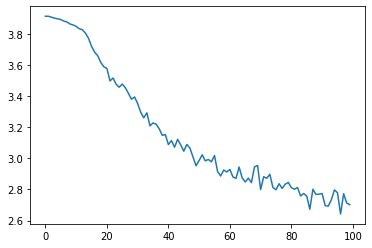

In [10]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [29]:
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    line_tensor = line_tensor.to(device)

    for i in range(line_tensor.size()[0]):
        hidden = hidden.to(device)
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_basic)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_countries[category_index]))
            predictions.append([value, all_countries[category_index]])

predict('Oslo')
predict('Malmo')
predict('London')
predict('Berlin')


> Oslo
(-2.51) Finland
(-2.67) Poland
(-3.16) Norway
(-3.25) Bulgaria
(-3.27) Uganda

> Malmo
(-2.15) Peru
(-2.44) Japan
(-2.52) Finland
(-2.55) Uganda
(-2.63) Italy

> London
(-1.99) Australia
(-2.09) United Kingdom
(-2.11) South Africa
(-2.33) United States
(-2.92) Poland

> Berlin
(-2.05) Germany
(-2.36) Netherlands
(-2.58) Australia
(-2.69) Switzerland
(-2.73) United Kingdom


## Pytorch RNN

In [12]:
def categoryToTensor(category):
    tensor = torch.zeros([1, len(all_countries)], dtype=torch.long)
    tensor[0][all_countries.index(category)] = 1
    return tensor

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_countries)
    line = randomChoice(city_dict[category])
    category_tensor = categoryToTensor(category)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [13]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)    
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

### Training 

In [14]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_pytorch = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_pytorch = model_pytorch.to(device)
optimizer = optim.SGD(model_pytorch.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_pytorch)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 3.7314 Ilo / Mexico ✗ (Peru)
10000 10% (0m 12s) 3.7829 Peris / Switzerland ✗ (Romania)
15000 15% (0m 18s) 4.1057 Kwinana / Japan ✗ (Australia)
20000 20% (0m 23s) 3.2620 Cehu Silvaniei / Romania ✓
25000 25% (0m 29s) 3.3079 Nord-Fron / Czechia ✗ (Norway)
30000 30% (0m 36s) 4.1697 Medan / Iran ✗ (Indonesia)
35000 35% (0m 42s) 3.4621 Burubaytal / Thailand ✗ (Kazakhstan)
40000 40% (0m 48s) 3.2459 Nesebar / South Africa ✗ (Bulgaria)
45000 45% (0m 54s) 2.8946 Puca Urco / Italy ✗ (Peru)
50000 50% (1m 0s) 2.6181 Klyuchi / Ukraine ✗ (Russia)
55000 55% (1m 6s) 4.2536 Ski / Finland ✗ (Norway)
60000 60% (1m 12s) 1.9804 Czestochowa / Poland ✓
65000 65% (1m 18s) 3.0318 Kavala / Finland ✗ (Greece)
70000 70% (1m 24s) 1.5221 Kirklareli / Turkey ✓
75000 75% (1m 30s) 3.9859 Aldo Bonzi / Greece ✗ (Argentina)
80000 80% (1m 36s) 4.8237 Can / Philippines ✗ (Turkey)
85000 85% (1m 42s) 0.9856 Okhtyrka / Ukraine ✓
90000 90% (1m 48s) 3.4166 Wangen bei Olten / Austria ✗ (Switzerland)
95000 95% (1m 

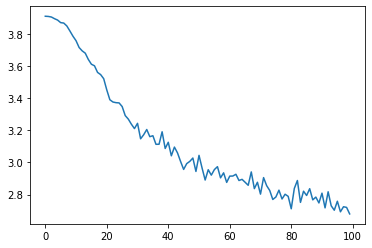

In [15]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [33]:
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output


def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_pytorch)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_countries[category_index]))
            predictions.append([value, all_countries[category_index]])

predict('Oslo')
predict('Malmo')
predict('London')
predict('Berlin')


> Oslo
(-2.15) Poland
(-2.37) Hungary
(-2.61) Finland
(-2.80) Uganda
(-2.83) Switzerland

> Malmo
(-2.15) Indonesia
(-2.33) Uganda
(-2.56) Peru
(-2.70) Japan
(-2.71) Philippines

> London
(-1.80) South Africa
(-2.23) United Kingdom
(-2.52) Netherlands
(-2.61) Austria
(-2.70) Australia

> Berlin
(-2.09) Bulgaria
(-2.35) Poland
(-2.70) Serbia
(-2.76) France
(-2.99) Indonesia


## GRU Net

In [17]:
class RNNPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPytorch, self).__init__()

        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True) # 1 is num_layers
        self.fc = nn.Linear(hidden_size, output_size)
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):

        hidden, output = self.rnn(x, hidden)

        output = output.contiguous().view(-1, self.hidden_size)
        output = self.fc(output)
        output = self.lsoftmax(output)
        
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

def train_pytorch_model(category_tensor, line_tensor, optim, criterion, model):
    
    model.train()
    hidden = model.initHidden()
    model.zero_grad()
    line_tensor = line_tensor.permute(1, 0, 2)    
    
    category_tensor = category_tensor.to(device)
    line_tensor = line_tensor.to(device)
    
    # Iterate through the whole line!
    hidden = hidden.to(device)
    output, hidden = model(line_tensor, hidden)

    loss = criterion(output, torch.topk(category_tensor, 1).indices.view(-1))
    
    # zero the parameter gradients
    optim.zero_grad()
    loss.backward()
    optim.step()

    return output, loss.item()

### Training 

In [18]:
criterion = nn.NLLLoss() # Because we are using Log_softmax
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
N_HIDDEN = 128

model_gru = RNNPytorch(n_letters, N_HIDDEN, n_categories) #Vocab_size, hidden size, output classes
model_gru = model_gru.to(device)
optimizer = optim.SGD(model_gru.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_pytorch_model(category_tensor, line_tensor, optimizer, criterion, model_gru)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 3.7630 Bibinagar / India ✓
10000 10% (0m 12s) 3.8866 Sarospatak / Russia ✗ (Hungary)
15000 15% (0m 18s) 3.9183 Vrbas / Egypt ✗ (Serbia)
20000 20% (0m 24s) 3.8513 Michalovce / Belgium ✗ (Slovakia)
25000 25% (0m 30s) 3.7667 Sao Marcos / Dominican Republic ✗ (Brazil)
30000 30% (0m 36s) 4.0889 Urla / Finland ✗ (Turkey)
35000 35% (0m 43s) 3.7734 Bugiri / Greece ✗ (Uganda)
40000 40% (0m 50s) 3.0852 Si Sa Ket / Egypt ✗ (Thailand)
45000 45% (0m 56s) 3.5130 Embu-Guacu / India ✗ (Brazil)
50000 50% (1m 2s) 3.2982 Tonisvorst / Russia ✗ (Germany)
55000 55% (1m 8s) 2.6236 Douar Snada / Egypt ✗ (Morocco)
60000 60% (1m 14s) 3.4597 Manokwari / Finland ✗ (Indonesia)
65000 65% (1m 20s) 3.1841 Szerencs / Belgium ✗ (Hungary)
70000 70% (1m 25s) 2.7600 Meycauayan / Slovakia ✗ (Philippines)
75000 75% (1m 31s) 2.3640 Neuenhof / Austria ✗ (Switzerland)
80000 80% (1m 37s) 4.4060 Colac / Serbia ✗ (Australia)
85000 85% (1m 43s) 5.1887 Llanera / Spain ✗ (Philippines)
90000 90% (1m 49s) 3.5613 Aguila

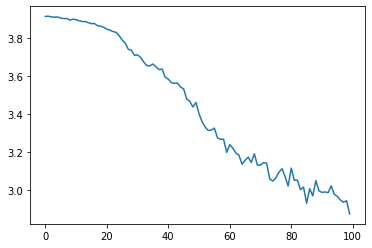

In [19]:
# PLOT THE RESULT

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [32]:
def evaluate(line_tensor, model):
    model.eval()
    hidden = model.initHidden()
    hidden = hidden.to(device)

    line_tensor = line_tensor.permute(1, 0, 2)
    line_tensor = line_tensor.to(device)
    output, hidden = model(line_tensor, hidden)
    
    return output

def predict(input_line, n_predictions=5):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line), model_gru)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_countries[category_index]))
            predictions.append([value, all_countries[category_index]])

predict('Oslo')
predict('Malmo')
predict('London')
predict('Berlin')


> Oslo
(-2.65) Portugal
(-2.70) Italy
(-2.74) Greece
(-2.97) Uganda
(-2.99) Colombia

> Malmo
(-2.48) Peru
(-2.52) Colombia
(-2.60) Uganda
(-2.66) Dominican Republic
(-2.85) Portugal

> London
(-2.07) South Africa
(-2.11) United Kingdom
(-2.70) United States
(-2.78) Switzerland
(-2.88) Canada

> Berlin
(-2.29) South Africa
(-2.36) Austria
(-2.42) Switzerland
(-2.48) Netherlands
(-2.51) Germany
